# Report Esame di Strumenti Informatici per la Fisica 

In questo notebook ho ottimizzato i codici scritti per l'esame di Laboratorio di Fisica Computazionale utilizzando f2py-jit per migliorarne le prestazioni. 

Per l'esame di Fisica Computazionale ho considerato il modello di Ising (ferromagnetico) nei casi di reticolo triangolare e di reticolo cubico. Uno degli obbiettivi dell'esame era di calcolare la capacità termica $C$ e la suscettività magnetica $\chi$ nel range di temperatura \([1.0 ; 5.0]\) e per diversi valori di $L$ (dimensione lineare del reticolo).

Queste quantità dipendono rispettivamente dall'energia media $\left\langle E\right\rangle$ e dalla magnetizzazione media $\left\langle |M|\right\rangle$.
I parametri $C$ e $\chi$ a partire dalle fluttuazioni statistiche rispettivamente dell'energia media totale e della magnetizzazione media totale.

Per prima cosa, ho riorganizzato il programma che avevo scritto in Fortran90 in modo che tutte le subroutine e function scritte fossere contenute in un unico modulo.

In [ ]:
''' fortran module
module ising_mod
  implicit none
  public :: initial, metropolis, DeltaE, data, initialize_w
  real (8), public :: T, E, M
  integer, public, dimension(:,:), allocatable :: spin
  real (8), public, dimension(-12:12) :: w
  real(8), public, dimension(4) :: cum
  integer, public, dimension(8) :: seed
  integer, public :: N, i, nequil, L, nmcs
  integer, public :: accept

contains

    subroutine initial(L_in, T_in, nequil, cum) 
      integer, intent(in) :: nequil, L_in
      real(8), intent(in) :: T_in
      real (8), dimension(4), intent(out) :: cum
      integer :: x, y, dE
      real :: rnd
        
        L=L_in
        T=T_in
        N = L * L

        if (allocated(spin)) deallocate(spin)
        allocate(spin(L, L))

        M = 0.0_double
        do y = 1, L
            do x = 1, L
                call random_number(rnd)
                if (rnd < 0.5) then
                    spin(x, y) = 1
                else
                    spin(x, y) = -1
                end if
                M = M + spin(x, y)
            end do
        end do

        E = 0.0_double
        do y = 1, L
            do x = 1, L
                E = E - 0.5_double * spin(x, y) * NeighborSum(x, y)
            end do
        end do

        accept = 0
        cum = 0.0_double
    end subroutine initial

    subroutine initialize_w(T)
        real (8), intent(in) :: T
        integer :: dE
        do dE = -12, 12, 4
            if (dE > 0) then
                w(dE) = exp(-dE / T)
            else
                w(dE) = 1.0_double
            end if
        end do
    end subroutine initialize_w

    subroutine metropolis()
        integer :: ispin, x, y, dE
        real :: rnd

        do ispin = 1, N
            call random_number(rnd)
              x = int(L * rnd) + 1
            call random_number(rnd)
              y = int(L * rnd) + 1
              dE = DeltaE(x, y)
            call random_number(rnd)
            if (rnd <= w(dE)) then
                spin(x, y) = -spin(x, y)
                accept = accept + 1
                M = M + 2 * spin(x, y)
                E = E + dE
            end if
        end do
    end subroutine metropolis

    function DeltaE(x, y) result(DeltaE_result)
        integer, intent(in) :: x, y
        integer :: DeltaE_result

        DeltaE_result = 2 * spin(x, y) * NeighborSum(x, y)
    end function DeltaE

    function NeighborSum(x, y) result(sum_neighbors)
        integer, intent(in) :: x, y
        integer :: sum_neighbors
        integer :: left, right, up, down, up_right, down_left

        left = spin(modulo(x - 2, L) + 1, y)
        right = spin(modulo(x, L) + 1, y)
        up = spin(x, modulo(y, L) + 1)
        down = spin(x, modulo(y - 2, L) + 1)
        up_right = spin(modulo(x, L) + 1, modulo(y, L) + 1)
        down_left = spin(modulo(x - 2, L) + 1, modulo(y - 2, L) + 1)

        sum_neighbors = left + right + up + down + up_right + down_left

        if (.not. allocated(spin)) then
          print *, "Errore: spin non allocato!"
        stop
        end if
    end function NeighborSum

    subroutine data(cum, iter)
        real(8), dimension(4), intent(inout) :: cum
        integer :: iter
    
        cum(1) = cum(1) + E
        cum(2) = cum(2) + E * E
        cum(3) = cum(3) + abs(M)
        cum(4) = cum(4) + abs(M * M) 
    end subroutine data

    subroutine dealloc()
      if (allocated(spin)) deallocate(spin) 
    end subroutine

end module ising_mod
'''

## Utilizzo di f2py-jit

Ho quindi scritto un programma in Python che fosse in grado di utilizzare i moduli Fortran. L'obiettivo é riprodurre i grafici ottenuti per l'energia e la magnetizzazione media per spin (in valore assoluto), così come per la capacità termica $C$ e la suscettività magnetica $\chi$, realizzati in precedenza per l'esame di Laboratorio di Fisica Computazionale (per confronto dei risultati ottenuti, vedi relazione pag.10).

In [7]:
import numpy as np
from f2py_jit import jit

f90 = jit('ising_tri.f90')

E' possibile settare questi parametri in modo diverso a seconda del risultato che si vuole ricreare.

In [8]:
# Parametri di simulazione
T_start = 1.0
T_end = 5.0
T_step = 0.2
L_values = [8, 16, 24, 32]
nequil = 10000  
nmcs = 100000   
runs = 4   

Il codice che ho scritto utilizza l'algoritmo di Metropolis, che introduce sia un problema di sottostima degli errori, che un problema di accuratezza delle quantità medie calcolate. Per aggirare questo problema ho suddiviso i dati simulati in quattro blocchi di dimensione nmcs, ognuno con seme diverso, e ho calcolato la media delle variabili di interesse su ogni blocco. 

Per ogni combinazione di $L$ e $T$, il mio programma esegue 4 simulazioni indipendenti per stimare le medie e gli errori.

In [9]:
#Apro file dati
with open('L_Cm_Chim_err.dat', 'w') as file1, open('L_Em_Mm_err.dat', 'w') as file2:

    #Primo ciclo su L
    for L in L_values:
        print(f"Dimensione reticolo L = {L}")
        
        #Secondo ciclo su T
        for k in range(int((T_end - T_start) / T_step) + 1):
            T = T_start + k * T_step
            print(f"Temperatura = {T}")

            #Inizializzo gli array 
            E_avg = np.zeros(4, dtype=np.float64)
            E2_avg = np.zeros(4, dtype=np.float64)
            M_avg = np.zeros(4, dtype=np.float64)
            M2_avg = np.zeros(4, dtype=np.float64)
            C_avg = np.zeros(4, dtype=np.float64)
            Chi_avg = np.zeros(4, dtype=np.float64)

            #Terzo ciclo -> 4 run -> var indip
            for run in range(runs):
                np.random.seed(run * 12345)
            
                #Inizializzo le w(T)
                f90.ising_mod.initialize_w(T)
                
                #Inizializzo array cum -> 4 posti bastano
                cum = np.zeros(4, dtype=np.float64)  
            
                #Inizializzo il sistema
                f90.ising_mod.initial(L, T, nequil)
                #print(f90.ising_mod.spin) 
            
                #Primi valori fino a nequil li scarto
                for _ in range(nequil):
                    f90.ising_mod.metropolis()

                #Questi valori tengo
                for _ in range(nmcs):
                    f90.ising_mod.metropolis()
                    f90.ising_mod.data(cum, _) 

                #Calcolo delle medie per il singolo run -> vado a prendere in cum
                N = L * L
                E_avg[run] = cum[0] / (N * nmcs)
                E2_avg[run] = cum[1] / (N * N * nmcs)
                M_avg[run] = cum[2] / (N * nmcs)
                M2_avg[run] = cum[3] / (N * N * nmcs)

                C_avg[run] = (E2_avg[run] - E_avg[run] ** 2) * N / (T ** 2)
                Chi_avg[run] = (M2_avg[run] - M_avg[run] ** 2) * N / T

            #Medie e deviazioni standard su 4 run
            E_mean, E_std = np.mean(E_avg), np.std(E_avg, ddof=1)
            C_mean, C_std = np.mean(C_avg), np.std(C_avg, ddof=1)
            M_mean, M_std = np.mean(M_avg), np.std(M_avg, ddof=1)
            Chi_mean, Chi_std = np.mean(Chi_avg), np.std(Chi_avg, ddof=1)

            #Scrivo nei file
            file1.write(f"{L} {T} {C_mean} {C_std} {Chi_mean} {Chi_std}\n")
            file2.write(f"{L} {T} {E_mean} {E_std} {M_mean} {M_std}\n")

        #Riga vuota
        file1.write("\n")
        file2.write("\n")

print("Simulazione completata!")
f90.ising_mod.dealloc()

Dimensione reticolo L = 8
Temperatura = 1.0
Temperatura = 1.2
Temperatura = 1.4
Temperatura = 1.6
Temperatura = 1.8
Temperatura = 2.0
Temperatura = 2.2
Temperatura = 2.4000000000000004
Temperatura = 2.6
Temperatura = 2.8
Temperatura = 3.0
Temperatura = 3.2
Temperatura = 3.4000000000000004
Temperatura = 3.6
Temperatura = 3.8000000000000003
Temperatura = 4.0
Temperatura = 4.2
Temperatura = 4.4
Temperatura = 4.6
Temperatura = 4.800000000000001
Temperatura = 5.0
Dimensione reticolo L = 16
Temperatura = 1.0
Temperatura = 1.2
Temperatura = 1.4
Temperatura = 1.6
Temperatura = 1.8
Temperatura = 2.0
Temperatura = 2.2
Temperatura = 2.4000000000000004
Temperatura = 2.6
Temperatura = 2.8
Temperatura = 3.0
Temperatura = 3.2
Temperatura = 3.4000000000000004
Temperatura = 3.6
Temperatura = 3.8000000000000003
Temperatura = 4.0
Temperatura = 4.2
Temperatura = 4.4
Temperatura = 4.6
Temperatura = 4.800000000000001
Temperatura = 5.0
Dimensione reticolo L = 24
Temperatura = 1.0
Temperatura = 1.2
Temperatur

Ciò che ho potuto maggiormente apprezzare nell'utilizzare f2py-jit è che le simulazioni impiegano molto meno tempo per essere completate. Per avere un confronto, una simulazione scritta interamente in Fortran90 dove $L$ cresceva fino al massimo valore di 32 impiegava quasi un'ora per essere completata.

## Plot ottenuti per $\left\langle E\right\rangle$ e $\left\langle |M|\right\rangle$

Ho poi plottato i grafici ottenuti rispettivamente per $\left\langle |M|\right\rangle$ e $\left\langle E\right\rangle$ in funzione della temperatura $T$ e della dimensione lineare del reticolo $L$ con i rispettivi errori.

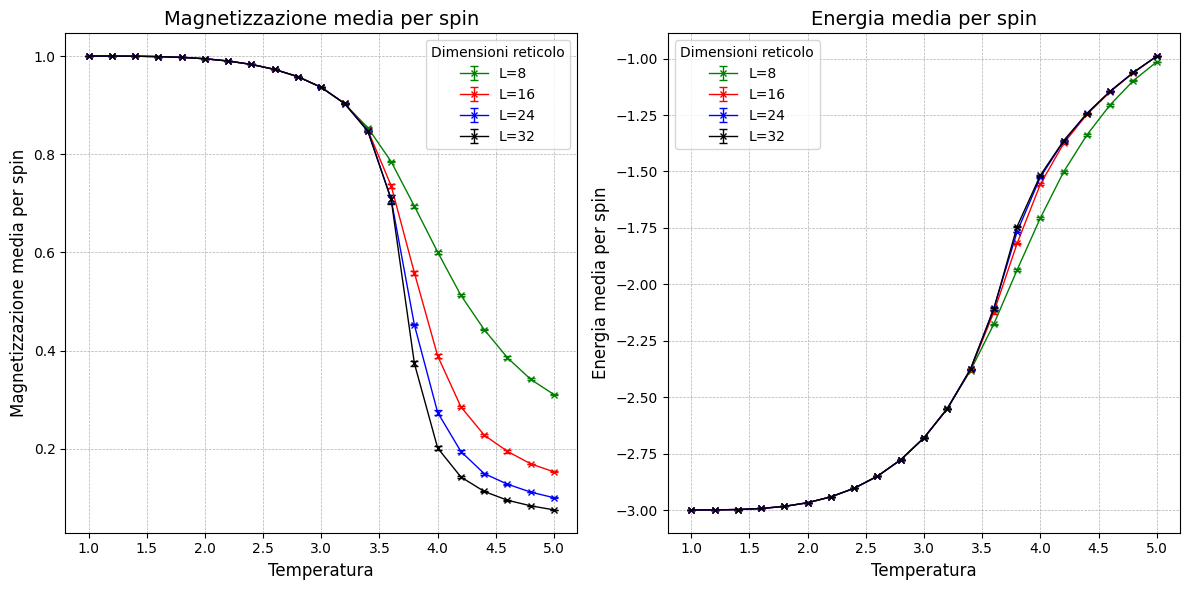

In [10]:
import matplotlib.pyplot as plt
import numpy as np

#Leggo i dati dal file
file_name = "L_Em_Mm_err.dat"
data = np.loadtxt(file_name)

#Scelgo le colonne da plottare
L = data[:, 0]
T = data[:, 1]
E = data[:, 2]
E_err = data[:, 3]
M = data[:, 4]
M_err = data[:, 5]

unique_L = np.unique(L)

#Come disegnare 
colors = ['green', 'red', 'blue', 'black', 'purple', 'orange', 'brown', 'pink']
markers = ['x']  

#Faccio due subplot -> plotto i grafici vicini
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

#Magnetizzazione
for i, l in enumerate(unique_L):
    subset = data[data[:, 0] == l]
    axs[0].errorbar(
        subset[:, 1], subset[:, 4], yerr=subset[:, 5],
        label=f"L={int(l)}",
        color=colors[i % len(colors)],
        marker=markers[i % len(markers)],
        linestyle='-', linewidth=1, markersize=5, capsize=3
    )
axs[0].set_xlabel(r"Temperatura", fontsize=12)
axs[0].set_ylabel(r"Magnetizzazione media per spin", fontsize=12)
axs[0].set_title("Magnetizzazione media per spin", fontsize=14)
axs[0].legend(title="Dimensioni reticolo", fontsize=10)
axs[0].grid(True, linestyle='--', linewidth=0.5)

#Energia media
for i, l in enumerate(unique_L):
    subset = data[data[:, 0] == l]
    axs[1].errorbar(
        subset[:, 1], subset[:, 2], yerr=subset[:, 3],
        label=f"L={int(l)}",
        color=colors[i % len(colors)],
        marker=markers[i % len(markers)],
        linestyle='-', linewidth=1, markersize=5, capsize=3
    )
axs[1].set_xlabel(r"Temperatura", fontsize=12)
axs[1].set_ylabel(r"Energia media per spin", fontsize=12)
axs[1].set_title("Energia media per spin", fontsize=14)
axs[1].legend(title="Dimensioni reticolo", fontsize=10)
axs[1].grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


## Plot ottenuti per $C$ e $\chi$

Ho poi plottato i grafici ottenuti rispettivamente per $\chi$ e $C$ in funzione della temperatura $T$ e della dimensione lineare del reticolo $L$ con i rispettivi errori.

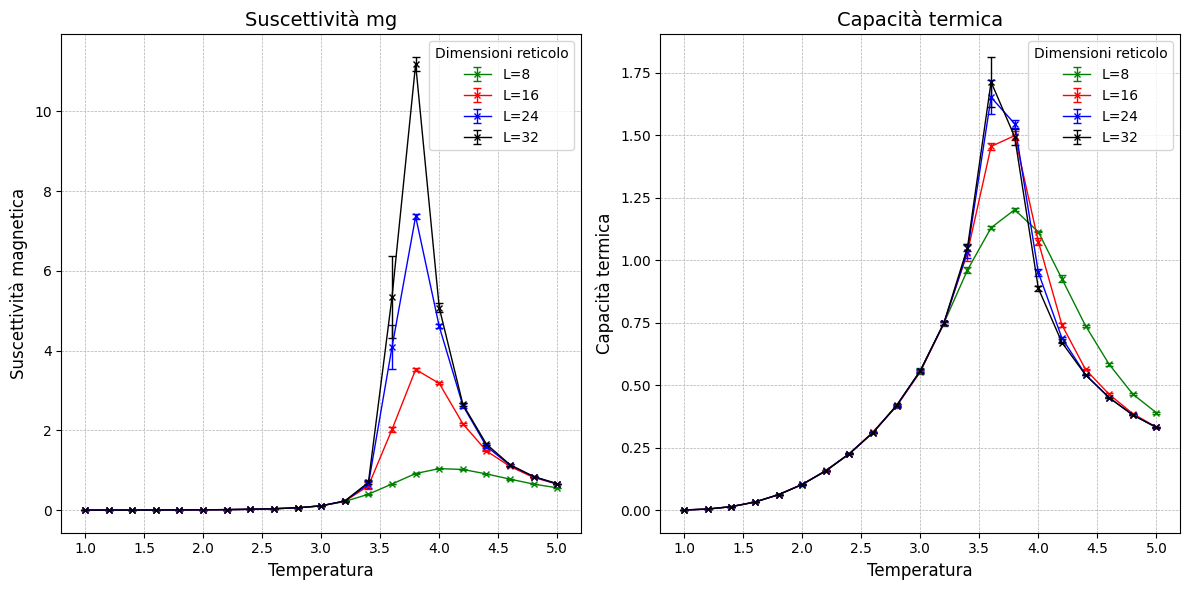

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#Leggo i dati dal file
file_name = "L_Cm_Chim_err.dat"
data = np.loadtxt(file_name)

#Scelgo le colonne da plottare
L = data[:, 0]
T = data[:, 1]
C = data[:, 2]
C_err = data[:, 3]
chi = data[:, 4]
chi_err = data[:, 5]

unique_L = np.unique(L)

#Come disegnare 
colors = ['green', 'red', 'blue', 'black', 'purple', 'orange', 'brown', 'pink']
markers = ['x']  

#Faccio due subplot -> plotto i grafici vicini
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

#Suscettività magnetica
for i, l in enumerate(unique_L):
    subset = data[data[:, 0] == l]
    axs[0].errorbar(
        subset[:, 1], subset[:, 4], yerr=subset[:, 5],
        label=f"L={int(l)}",
        color=colors[i % len(colors)],
        marker=markers[i % len(markers)],
        linestyle='-', linewidth=1, markersize=5, capsize=3
    )
axs[0].set_xlabel(r"Temperatura", fontsize=12)
axs[0].set_ylabel(r"Suscettività magnetica", fontsize=12)
axs[0].set_title("Suscettività mg", fontsize=14)
axs[0].legend(title="Dimensioni reticolo", fontsize=10)
axs[0].grid(True, linestyle='--', linewidth=0.5)

#Calore Specifico
for i, l in enumerate(unique_L):
    subset = data[data[:, 0] == l]
    axs[1].errorbar(
        subset[:, 1], subset[:, 2], yerr=subset[:, 3],
        label=f"L={int(l)}",
        color=colors[i % len(colors)],
        marker=markers[i % len(markers)],
        linestyle='-', linewidth=1, markersize=5, capsize=3
    )
axs[1].set_xlabel(r"Temperatura", fontsize=12)
axs[1].set_ylabel(r"Capacità termica", fontsize=12)
axs[1].set_title("Capacità termica", fontsize=14)
axs[1].legend(title="Dimensioni reticolo", fontsize=10)
axs[1].grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()
